# Exploratory Analysis

In [2]:
import pandas as pd

df = pd.read_csv("../../data/bioactivity_processed_data.csv")

Lipinski descriptors: rule of thumb for evaluaitng the **druglikeness** of compounds. Based ADME (pharmacokinetic profile)

The rule states:
- Molecular weight < 500 Dalton
- Octanol-water partition coefficient (LogP) < 5
- Hydrogen bond donors < 5
- Hydrogen bond acceptors < 10

In [4]:
import numpy as np 
from rdkit import Chem 
from rdkit.Chem import Descriptors, Lipinski

In [7]:
def lipinski(smiles, verbose=False):
    moldata= []

    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData=np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([ desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])
        
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW", "LogP", "NumHDonors", "NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData, columns=columnNames)

    return descriptors






In [8]:
df_lipinski = lipinski(df.canonical_smiles)

In [9]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,281.271,1.89262,0.0,5.0
1,415.589,3.81320,0.0,2.0
2,421.190,2.66050,0.0,4.0
3,293.347,3.63080,0.0,3.0
4,338.344,3.53900,0.0,5.0
...,...,...,...,...
240,328.466,3.34562,1.0,5.0
241,222.379,-1.99300,1.0,3.0
242,485.559,0.54470,5.0,7.0
243,222.379,-1.99300,1.0,3.0


In [10]:
df_comb = pd.concat([df, df_lipinski], axis=1)
df_comb

,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,7200.00,Intermediate,281.271,1.89262,0.0,5.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,9400.00,Intermediate,415.589,3.81320,0.0,2.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,13500.00,inactive,421.190,2.66050,0.0,4.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,13110.00,inactive,293.347,3.63080,0.0,3.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],2000.00,Intermediate,338.344,3.53900,0.0,5.0
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,380.19,active,328.466,3.34562,1.0,5.0
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.00,active,222.379,-1.99300,1.0,3.0
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,161.00,active,485.559,0.54470,5.0,7.0
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],165.96,active,222.379,-1.99300,1.0,3.0


Converting the IC50 to pIC50
reason: negative log transformation, since the original dist may be not uniform

In [18]:
import numpy as np 

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) #converting from nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop("standard_value_norm", axis=1)

    return x



In [12]:
df_comb.standard_value.describe()

count    2.450000e+02
mean     6.893878e+04
std      1.851962e+05
min      5.000000e+01
25%      5.000000e+03
50%      1.500000e+04
75%      4.700000e+04
max      2.000000e+06
Name: standard_value, dtype: float64

In [19]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100_000_000:
            i = 100_000_000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

In [20]:
df_norm = norm_value(df_comb)
df_norm

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,Intermediate,281.271,1.89262,0.0,5.0,7200.00
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,Intermediate,415.589,3.81320,0.0,2.0,9400.00
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,13500.00
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,13110.00
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],Intermediate,338.344,3.53900,0.0,5.0,2000.00
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,380.19
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,165.00
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,161.00
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,165.96


In [21]:
df_norm.standard_value_norm.describe()

count    2.450000e+02
mean     6.893878e+04
std      1.851962e+05
min      5.000000e+01
25%      5.000000e+03
50%      1.500000e+04
75%      4.700000e+04
max      2.000000e+06
Name: standard_value_norm, dtype: float64

In [22]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,Intermediate,281.271,1.89262,0.0,5.0,5.142668
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,Intermediate,415.589,3.81320,0.0,2.0,5.026872
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],Intermediate,338.344,3.53900,0.0,5.0,5.698970
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,6.419999
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.782516
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,6.793174
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.779997


In [23]:
df_final.pIC50.describe()

count    245.000000
mean       4.894585
std        0.911338
min        2.698970
25%        4.327902
50%        4.823909
75%        5.301030
max        7.301030
Name: pIC50, dtype: float64

Moving forward with two classes active or inactive

In [25]:
df_active_inactive = df_final[df_final.bioactivity_class != "Intermediate"]
df_active_inactive

,molecule_chembl_id,canonical_smiles,bioactivity_class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,421.190,2.66050,0.0,4.0,4.869666
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,293.347,3.63080,0.0,3.0,4.882397
5,CHEMBL365134,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c(Br)cccc21,active,372.243,4.39330,0.0,3.0,6.008774
7,CHEMBL190743,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccc(I)cc21,active,419.243,4.23540,0.0,3.0,6.022276
8,CHEMBL365469,O=C1C(=O)N(Cc2cc3ccccc3s2)c2cccc(Cl)c21,inactive,327.792,4.28420,0.0,3.0,4.950782
...,...,...,...,...,...,...,...,...
240,CHEMBL4590273,Cc1cccc2nc(CSC(=S)NCc3cccnc3)cn12,active,328.466,3.34562,1.0,5.0,6.419999
241,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.782516
242,CHEMBL2365410,CC(C)C[C@H](NC(=O)OCc1ccccc1)C(=O)N[C@@H](CC1C...,active,485.559,0.54470,5.0,7.0,6.793174
243,CHEMBL5436771,S=C([S-])NCc1cccnc1.[K+],active,222.379,-1.99300,1.0,3.0,6.779997


#### Chemical Space Analysis

In [27]:
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt 

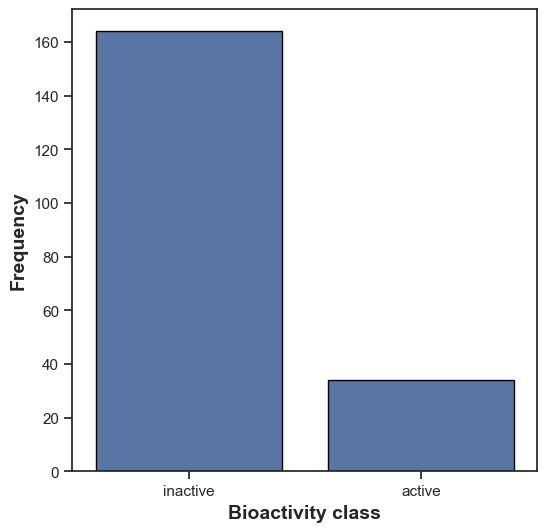

In [28]:
plt.figure(figsize=(6,6))

sns.countplot(x='bioactivity_class', data=df_active_inactive, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('../../data/class_dist_bioactivity.pdf')

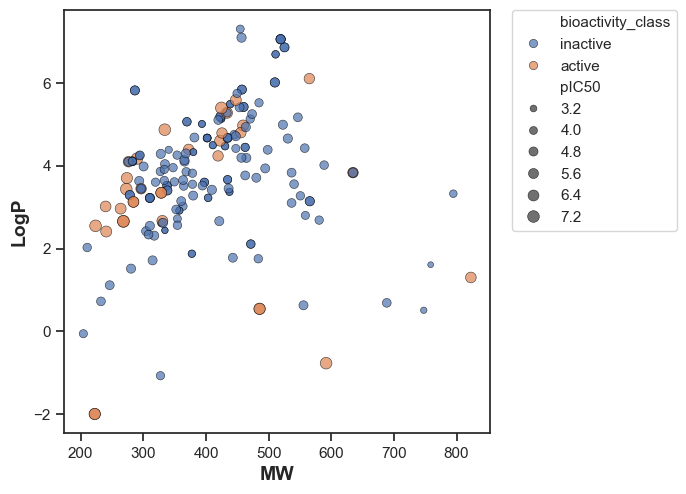

In [29]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x="MW", y='LogP', data=df_active_inactive, hue='bioactivity_class',
                size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('../../data/mw_vs_logp.pdf')

Box Plots

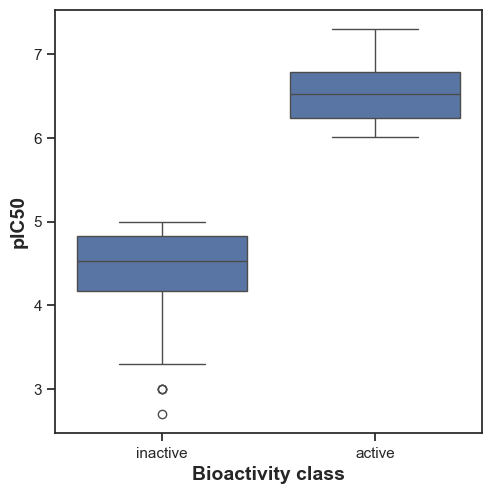

In [30]:
#pIC50

plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='pIC50', data=df_active_inactive)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50', fontsize=14, fontweight='bold')

plt.savefig('../../data/boxplot_pIC50.pdf')


In [45]:
def mannwhitney(df_2class, descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  active = df[df['bioactivity_class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'bioactivity_class']
  df = df_2class[selection]
  inactive = df[df['bioactivity_class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(f"../../data/{filename}")

  return results

In [36]:
mannwhitney(df_active_inactive, "pIC50")

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,5576.0,4.760913e-20,0.05,Different distribution (reject H0)


Molecular weight explorations

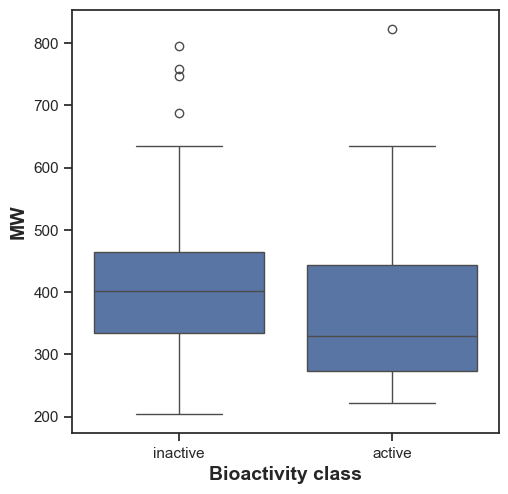

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='MW', data=df_active_inactive)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('../../data/boxplot_MW.pdf')

In [38]:
mannwhitney(df_active_inactive, "MW")

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1996.5,0.009286,0.05,Different distribution (reject H0)


LogP

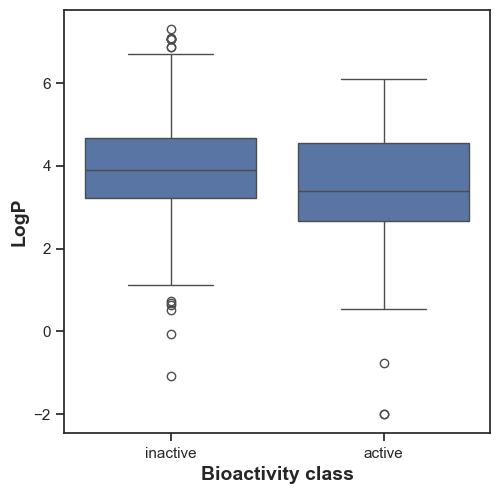

In [39]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='LogP', data=df_active_inactive)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('../../data/boxplot_LogP.pdf')

In [40]:
mannwhitney(df_active_inactive, "LogP")

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,2222.5,0.063155,0.05,Same distribution (fail to reject H0)


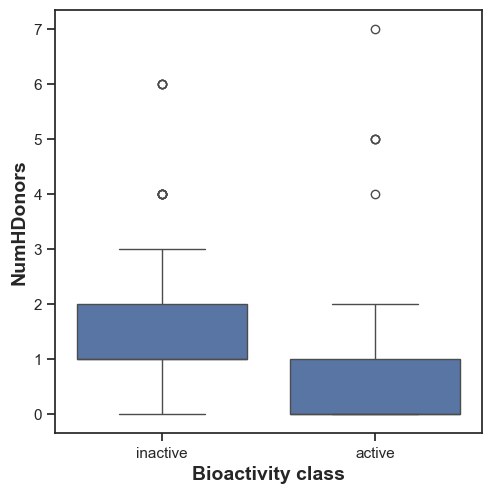

In [41]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df_active_inactive)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('../../data/boxplot_NumHDonors.pdf')

In [42]:
mannwhitney(df_active_inactive, "NumHDonors")

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,1831.5,0.001049,0.05,Different distribution (reject H0)


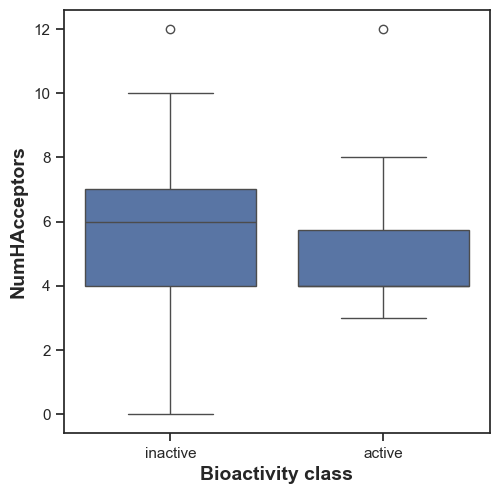

In [43]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data=df_active_inactive)
plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('../../data/boxplot_NumHAcceptors.pdf')

In [44]:
mannwhitney(df_active_inactive, "NumHAcceptors")

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,2033.5,0.012124,0.05,Different distribution (reject H0)


In [47]:
df_active_inactive.to_csv("../../data/data_active_inactive.csv", index=False)